In [1]:
import sys
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
import torch
from torch.utils import model_zoo
from collections import OrderedDict

sys.path.append('../src')
sys.path.append('../src')
from utils import DataHandler
import factory

In [2]:
dh = DataHandler()

In [3]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img)
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


def concat_tiles(image_list):
    image = []
    row_num = int(np.sqrt(len(image_list)))

    for i in range(row_num):
        v = [image_list[(row_num * i) + j] for j in range(row_num)]
        image.append(cv2.hconcat(v))

    return cv2.vconcat(image)

    
def show_gradcam(model, imga_id):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    tiles = []
    for i in range(36):
            tile = cv2.imread(f'../data/input/train_tile_256x36/{imga_id}_{i}.png')
            tiles.append(tile)
    img = concat_tiles(tiles)
#     img = cv2.imread(f'../data/input/train_images/{img_id}.png')
    
    features_fn = nn.Sequential(*list(model.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
    
    input_data = torch.tensor(img.reshape(1, img.shape[2], img.shape[0], img.shape[1])).to(device).float()
#     pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), k=1)
    pp, cc = torch.topk(model(input_data), k=1)
    sal = GradCam(input_data.to(device), cc[0][0], features_fn, classifier_fn)
#     print(sal)
    img_sal = cv2.resize(sal, img.shape[0:2])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    ax1.imshow(img)

    ax2.imshow(img)
    ax2.imshow(np.array(img_sal), alpha=0.5, cmap='jet')

# Main

In [4]:
log_dir = Path('../logs/clf_resnet18_20200703133354_0.827/')
cfg = dh.load(log_dir / 'config.yml')
oof = np.load(log_dir / 'oof.npy')

In [6]:
train_df = pd.read_csv('../data/input/train.csv')
drop_idx = np.load('../pickle/duplicate_img_idx.npy')
train_df = train_df.drop(drop_idx, axis=0).reset_index(drop=True)

trn_x, val_x = train_test_split(train_df,
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=2020)
# if oof.shape[1] == 1:
#     val_x['oof'] = oof
# else:
#     val_x['oof'] = np.argmax(oof, axis=1)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg.model.multi_gpu = False

model = factory.get_model(cfg).to(device)
model.load_state_dict(torch.load(log_dir / 'weight_best.pt'))

<All keys matched successfully>

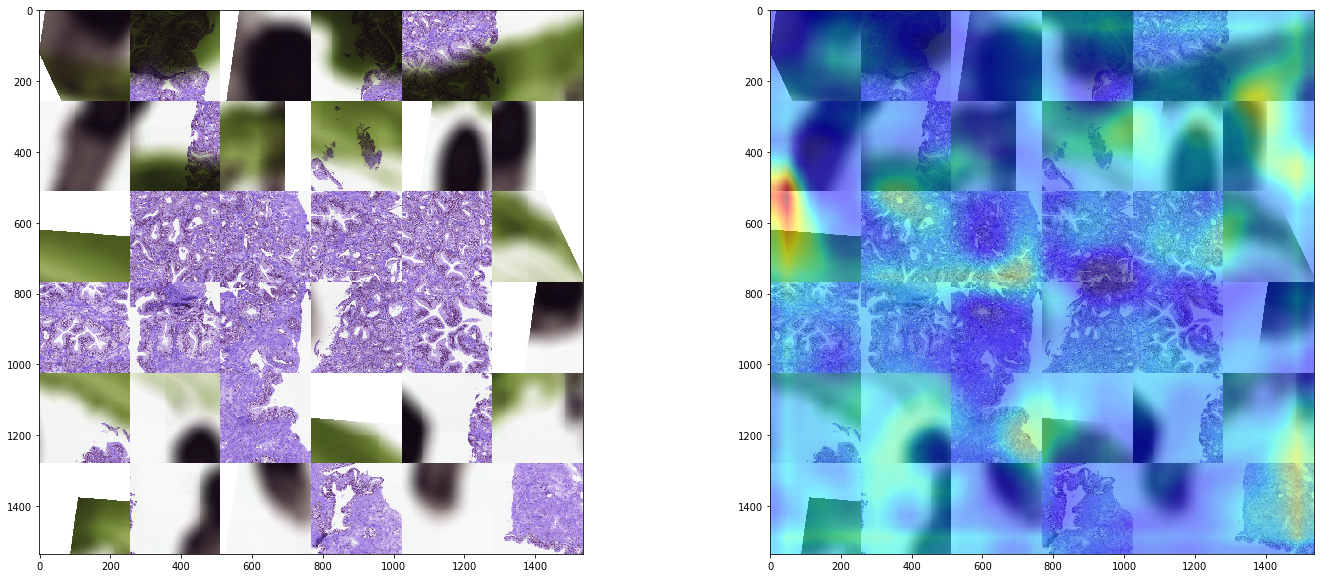

In [8]:
img_id = '4a3e6e77b42a7e8f8b2dec472667bdbe'
show_gradcam(model, img_id)

In [ ]:
val_x['diff'] = np.abs(val_x['isup_grade'] - val_x['oof'])

In [ ]:
val_x

In [32]:
a = np.load('../data/input/img_hash_sims.npy')
a_ = a - np.eye(a.shape[0])

In [36]:
idx = np.where(np.max(a_, axis=1) >= 0.96)[0]

In [38]:
np.argmax(a_, axis=1)[idx]

array([ 7809,  4201,  1720,  7194,  5795,  3886,  4505,  9422,  3691,
        3498,  9124,  7057, 10048,  6482,  3671,  7963,  1745,  9059,
        3534,  7704,  6794,  4116,   384,  1181,  8134,  9116,  9110,
        4066,  7483,  2380, 10225,  7452,  8548,  2210,  3939,  7599,
        8147,  4950,  6155,  6852,  8467,  5182,  7432,   706,  1475,
        9025,  7186,  5073,   989,   547,  6176,  7317,  8137,   435,
        7417,  2412,  8193,  2051,  1717,  8947,  9504,  6284,   259,
        6619,   463,  6907,  5031,  9796,  7842,  5147,  5319,  2714,
        4769,  3665,  4867,  3124,  7260,  4894,  7023,  9602,  9351,
        6741,   416,  9160,  9940,  2856,  8878,  3700,  4178,  9649,
         910,  7483,  8729,  8589,  4276,  5760,  1628,  2948,  9413,
        4569,  5422,   756,  3620,   414,  5315,  7857,  3823,  3920,
        3242,  2292,  6510,  7834,  2584,  9911,  1504,  8896, 10163,
          12,  7500,  4828,  7290,  1077,  1857,  3883,  2692,  3943,
        2985,  2294,